<a href="https://colab.research.google.com/github/marrvinn/marrvinn/blob/main/Schneidzeit/04_cut_time_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.0 Import and Install

In [ ]:
import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.patches as patches
from matplotlib import pyplot as plt
import glob
from os import listdir

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 4.1 Read preprocessed Data

In [ ]:
data_path = '/content/drive/MyDrive/PJS/01_Input/Daten_v1_clean/01_Preprocessed/prep_flyerdata_135_ma_a18.csv'
df = pd.read_csv(data_path, index_col= 0)

In [ ]:
# neue Daten sind sauber
# df = df.loc[(df[['amount']] != 0).all(axis=1)] 

df[df.isnull().any(axis=1)]

,DocName,x_left,x_right,y_bot,y_top,x_sheetsize,y_sheetsize,BSig,MarBot,MarLeft,...,cut_time,cuts,layer,cut_layer,format,grammatur,width,heigh,new_layer,count_cut


In [ ]:
df_time_matrix = pd.read_csv('/content/drive/MyDrive/PJS/01_Input/Daten_v1_clean/04_Team_Schneidzeit/cut_time_constants.csv', index_col= 0)
df_time_matrix

,250,170,135
b17,0.004834,NaN,0.004365
a18,NaN,0.011078,0.011486


# 4.2 Calculation Cutting Time with Constant
- Berechnung der Schneidzeit auf Basis einer Konstante aus den Vergangenheitsdaten.
- Zur Bestimmung der optimalen Schneidzeit, wird die optimale Anzahl an cuts benötigt --> Optimierungsproblem
- Näherungsweise Lösung aus dem Preprocessing erlaubt Vorhersage mit Extra Trees Regressor.
- Berechnung über eine Konstante sind ohne eine reale Schätzung der cuts nicht aussagekräftig.
- Die reell geschätzen cuts, könnte auf Basis eines Faktors, der die Abweichungs der historischen cuts von den optimalen cuts zusammenfasst, gut geschätzt werden.
- Format und Grammatur am besten als separate Tabelle in DB gespeichert mit Key zu den jeweiligen Flyerdaten - alternativ Spalte in der in jeder Zelle der Wert steht. Erhöhter Speicherbedarf, zunächst vernachlässigbar, funktionell.

In [ ]:
# Auswahl Format und Grammatur als string
format = str(df.loc[1, 'format'])
grammatur = str(df.loc[1, 'grammatur'])

print('format:', format, 'und', 'grammatur:', grammatur)

format: a18 und grammatur: 135


In [ ]:
# Auswahl der richtigen Schneidzeit Konstante mit strings
const_cut_time = df_time_matrix.loc[format, grammatur]
const_cut_time

0.0114858281063378

In [ ]:
# Multiplizieren der benötigten new_cut auf Basis der new_layer und der count_cut
df['new_cut'] = df['new_layer'].multiply(df['count_cut'], fill_value='error')

In [ ]:
# Berechne Schneidzeit mit Konstante
df = df.assign(cutting_time_count = lambda x: (x['new_cut'] * const_cut_time))

# 4.3 Evaluation Cutting Time with Constant

In [ ]:
#df = df.assign(cutting_time_count_min = lambda x: (x['cutting_time_count'] * 60))

In [ ]:
#df['cutting_time_count_min']

In [ ]:
cols = df.columns
cols

Index(['DocName', 'x_left', 'x_right', 'y_bot', 'y_top', 'x_sheetsize',
       'y_sheetsize', 'BSig', 'MarBot', 'MarLeft', 'MarRight', 'MarTop',
       'Orient', 'JobID', 'ProjectID', 'ProductPart', 'Day', 'Month', 'Year',
       'Priority', 'amount', 'cut_time', 'cuts', 'layer', 'cut_layer',
       'format', 'grammatur', 'width', 'heigh', 'new_layer', 'count_cut',
       'num_flyer', 'new_cut', 'cutting_time_count'],
      dtype='object')

In [ ]:
df_comp = df[['JobID', 'ProjectID', 'DocName', 'amount', 'cut_time', 'cuts', 'layer', 'cut_layer', 'format', 'grammatur', 'new_layer', 'count_cut', 'new_cut', 'cutting_time_count']] # 'cutting_time_min']]

In [ ]:
check = df_comp['cut_time'] / df_comp['cuts']
avg_act_time = check.mean()
avg_act_time
# muss natürlich das gleiche sein, weil man ja new_cut* avg_act_time nimmt

0.011506434634032336

In [ ]:
check2 = df_comp['cutting_time_count'] / df_comp['new_cut']
avg_pred_time = check2.mean()
avg_pred_time

0.011485828106337696

## Compare Cutting Time in Total


In [ ]:
sum_cut_time=df['cut_time'].sum()
sum_cut_time

908.3476

In [ ]:
sum_cuts = df['cuts'].sum()
sum_cuts

100509.0

In [ ]:
sum_new_time = df['cutting_time_count'].sum()
sum_new_time

1325.8206241426785

In [ ]:
sum_new_cut = df['new_cut'].sum()
sum_new_cut

115431.0

## Variance in Total

In [ ]:
variance = (abs((sum_cut_time - sum_new_time)) / sum_new_time) * 100
variance

## Variance per JobID

In [ ]:
def calc_diff(df_comp):

  diff_list = []
  list_cut_time = []
  list_cutting = []

  for index, row in df_comp.iterrows():
    list_cut_time.append(row['cut_time'])
    list_cutting.append(row['cutting_time_count'])

    diff = (abs((row['cut_time'] - row['cutting_time_count'])) / row['cutting_time_count']) 
    diff_list.append(diff)
  # print(list_cut_time)
  # print(list_cutting)
  # print(diff_list)
  print((sum(diff_list) / len(diff_list))*100)
  return diff_list

In [ ]:
diff = calc_diff(df_comp)

# 4.4 Feature Engineering

## Klassifizierung der Komplexität (eingefügt aus 02_Matrix)

0 = Leicht

1 = Mittel

2 = Schwierig

In [ ]:
def get_abin(df, job_ID):
  abin = df.loc[df['JobID'] == job_ID]
  return abin

In [ ]:
def calc_measures(df):
  df['width'] = abs(df['x_left'] - df['x_right'])
  df['height'] = abs(df['y_bot'] - df['y_top'])
  return df

In [ ]:
def calc_complex(dfs):
  for df in dfs:
    df = dfs[df]

    # Berechnung der Anzahl Flyer pro JobID
    df['num_flyer'] = df.groupby('JobID')['JobID'].transform('count')
    df['num_flyer'] = df['num_flyer'].astype(float)

    # Einstufung der Komplexität der einzelnen Layouts
    df['complexity'] = ''
    # Wenn 4 oder weniger Flyer auf dem Bogen sind, ist das Layout einfach = 0
    df.loc[df["num_flyer"] <= 15, "complexity"] = 0
    # Wenn mehr als 5 Flyer auf dem Bogen sind, ist das Layout mittel = 1
    df.loc[df["num_flyer"] >= 16, "complexity"] = 1
    

    # Berechnung der hohen Komplexität: Wenn es eine große Anzahl an Flyer und viele unterschiedliche Größen gibt = 2 

    list_JobID = np.unique(df['JobID']).tolist()
    df = calc_measures(df)

    for id in list_JobID:

      abin = get_abin(df, id)
      for index, row in abin.iterrows():
      # Zur Berechnung der unterschiedlichen Größen:
        x_boxes = abin['width'].tolist() + abin['height'].tolist()
        y_boxes = abin['width'].tolist() + abin['height'].tolist()
        x_boxes = pd.unique(x_boxes).tolist()
        y_boxes = pd.unique(y_boxes).tolist()
        boxes = list((x_boxes) + (y_boxes))
      # Gibt es viele unterschiedliche Größen? 50 = 25 unterschiedlich große Flyer
      #####
      #####
      # Evtl. hier ersetzen durch: wenn die Länge der Liste gleich lang oder fast so lang ist wie die Anzahl an Flyer
      ####
      ####
        if len(boxes) >= 60:
          df.loc[df["num_flyer"] >= 16, "complexity"] = 2

    
    print(df)
  return dfs

In [ ]:
dfs = calc_complex(dfs)

NameError: ignored

Matrix Komplexität

In [ ]:
def calc_complex_time(dfs):
  list_zero = []
  list_one = []
  list_two = []
    

  for i in dfs:
    complex_dict = dfs[i].groupby('complexity')['cut_time'].mean()
    complex_dict = complex_dict.to_dict()

    key = 0
    if key in complex_dict.keys():
      list_zero.append(complex_dict[key])

    key = 1
    if key in complex_dict.keys():
      list_one.append(complex_dict[key])

    key = 2
    if key in complex_dict.keys():
      list_two.append(complex_dict[key])
  
  print('list0', list_zero)
  print('list1', list_one)
  print('list2', list_two)

  
  return list_zero, list_one, list_two, test

In [ ]:
list_zero, list_one, list_two, test = calc_complex_time(dfs=dfs)

In [ ]:
def calc_factor(list_zero, list_one, list_two):
  mean_list_zero = sum(list_zero) / len(list_zero)
  mean_list_one = sum(list_one) / len(list_one)
  mean_list_two = sum(list_two) / len(list_two)
  print('0:', mean_list_zero)
  print('1:', mean_list_one)
  print('2:', mean_list_two)

  # factor1 = mean_list_one / mean_list_zero
  # print('factor1',factor1)

  # factor2 = mean_list_two / mean_list_zero
  # print('factor2',factor2)

  #factor = {'factor1': '', 'factor2': ''}
  factor = pd.DataFrame(columns = ['1', '2'], index = ['factor'])

  factor['1'] = mean_list_one / mean_list_zero

  factor['2'] = mean_list_two / mean_list_zero

  
  print(factor)
  return factor

# Weitere Überlegung
# Alternative Faktorberechnung basierend auf der jeweiligen durchschnittlichen Schneidzeit


In [ ]:
factor = calc_factor(list_zero, list_one, list_two)

In [ ]:
factor

# 4.5 ExtraTrees

In [ ]:
# Calculate num_fyler
df['num_flyer'] = df.groupby('JobID')['JobID'].transform('count')

### Remove outliers

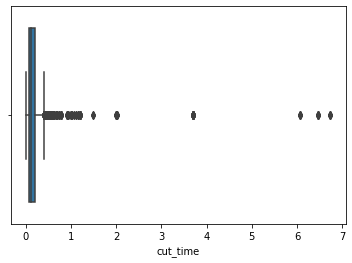

In [ ]:
# Boxplot to display outliers
import seaborn as sns
sns.boxplot(x=df['cut_time'])

## Berechnung mit errechneten Werten (aus 03_Preprocessing)

In [ ]:
# own_reduced_df = df mit den Werten, die wir selbst berechnet haben
own_reduced_df = df[['JobID',  'new_layer', 'new_cut', 'num_flyer', 'cut_time']]
own_reduced_df = own_reduced_df.drop_duplicates()

In [ ]:
array = own_reduced_df.values
X = array[:,1:4]
y = array[:,4]
X

array([[ 2.,  8.,  1.],
       [ 2.,  8.,  4.],
       [ 2.,  8.,  1.],
       ...,
       [ 2., 14.,  4.],
       [ 1.,  7.,  3.],
       [ 1.,  7.,  4.]])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
etr_pred = reg.predict(X_test)
print('reg_score', reg.score(X_test, y_test))
from sklearn import metrics
Mae = metrics.mean_absolute_error(y_test, etr_pred)
print('MAE', metrics.mean_absolute_error(y_test, etr_pred))
print('MSE', metrics.mean_squared_error(y_test, etr_pred))
import numpy as np
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test, etr_pred)))
from sklearn.metrics import r2_score
print('R-Squared Score', r2_score(y_test,etr_pred))

reg_score 0.7332637848788515
MAE 0.05979650251635191
MSE 0.009989913642540373
RMSE 0.09994955548945865
R-Squared Score 0.7332637848788515


In [ ]:
# Speichern der Vorhersage im df
own_pred = reg.predict(X)
own_reduced_df['own_pred'] = own_pred
own_reduced_df

,JobID,new_layer,new_cut,num_flyer,cut_time,own_pred
0,6665075005,2.0,8.0,1,0.0704,0.123080
1,6665075003,2.0,8.0,4,0.0509,0.050900
5,6665075001,2.0,8.0,1,0.0364,0.123080
6,6665075006,2.0,8.0,1,0.0998,0.123080
7,6665075004,2.0,8.0,1,0.1036,0.123080
...,...,...,...,...,...,...
4123,6713200905,9.0,81.0,3,1.4915,0.901268
4126,6712464613,1.0,11.0,8,0.0807,0.098012
4134,6715117115,2.0,14.0,4,0.1801,0.132521
4138,6712464615,1.0,7.0,3,0.0581,0.129050


### Abweichung gesamt

In [ ]:
sum_pred_time = own_reduced_df['own_pred'].sum()
sum_pred_time

183.2089898538975

In [ ]:
sum_time = own_reduced_df['cut_time'].sum()
sum_time

183.33599999999998

In [ ]:
# Differenz
diff = ((sum_time - sum_pred_time)/ sum_pred_time) * 100
diff

0.06932528049184604

### Abweichung pro JobID

In [ ]:
def calc_own_diff(df_comp):

  diff_list = []
  list_cut_time = []
  list_cutting = []

  for index, row in df_comp.iterrows():
    list_cut_time.append(row['cut_time'])
    list_cutting.append(row['own_pred'])

    diff = (abs((row['cut_time'] - row['own_pred'])) / row['own_pred']) 
    diff_list.append(diff)
  # print(list_cut_time)
  # print(list_cutting)
  # print(diff_list)
  print((sum(diff_list) / len(diff_list))*100)
  return diff_list

In [ ]:
own_diff = calc_own_diff(df_comp=own_reduced_df)

35.28534513318496


## Vorhersage mit historischen Werten

In [ ]:
# reduced_df = df mit ursprünglichen cut/ layer werten
reduced_df = df[['JobID', 'num_flyer', 'layer', 'cuts', 'cut_time']]
reduced_df = reduced_df.drop_duplicates()

In [ ]:
array = reduced_df.values
X = array[:,1:4]
y = array[:,4]
X

array([[ 1.,  1.,  5.],
       [ 4.,  1.,  5.],
       [ 1.,  1.,  5.],
       ...,
       [ 4.,  2., 13.],
       [ 3.,  1.,  8.],
       [ 4.,  1.,  7.]])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
etr_pred = reg.predict(X_test)
print('reg_score', reg.score(X_test, y_test))
from sklearn import metrics
Mae = metrics.mean_absolute_error(y_test, etr_pred)
print('MAE', metrics.mean_absolute_error(y_test, etr_pred))
print('MSE', metrics.mean_squared_error(y_test, etr_pred))
import numpy as np
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test, etr_pred)))
from sklearn.metrics import r2_score
print('R-Squared Score', r2_score(y_test,etr_pred))

reg_score 0.7176850901954079
MAE 0.05887506111602692
MSE 0.010573373276922671
RMSE 0.10282690930356057
R-Squared Score 0.7176850901954079


In [ ]:
# Speichern der Vorhersage im df
pred = reg.predict(X)
reduced_df['pred'] = pred
reduced_df

,JobID,num_flyer,layer,cuts,cut_time,pred
0,6665075005,1,1.0,5.0,0.0704,0.074729
1,6665075003,4,1.0,5.0,0.0509,0.050900
5,6665075001,1,1.0,5.0,0.0364,0.074729
6,6665075006,1,1.0,7.0,0.0998,0.085840
7,6665075004,1,1.0,5.0,0.1036,0.074729
...,...,...,...,...,...,...
4123,6713200905,3,9.0,113.0,1.4915,1.060202
4126,6712464613,8,1.0,9.0,0.0807,0.091538
4134,6715117115,4,2.0,13.0,0.1801,0.167481
4138,6712464615,3,1.0,8.0,0.0581,0.104380


### Abweichung gesamt

In [ ]:
sum_pred_time = reduced_df['pred'].sum()
sum_pred_time

184.74118209660986

In [ ]:
sum_time = reduced_df['cut_time'].sum()
sum_time

183.33599999999998

In [ ]:
# Differenz
diff = ((sum_time - sum_pred_time)/ sum_pred_time) * 100
diff

-0.7606220121916517

### Abweichung pro JobID

In [ ]:
def calc_own_diff(df_comp):

  diff_list = []
  list_cut_time = []
  list_cutting = []

  for index, row in df_comp.iterrows():
    list_cut_time.append(row['cut_time'])
    list_cutting.append(row['pred'])

    diff = (abs((row['cut_time'] - row['pred'])) / row['pred']) 
    diff_list.append(diff)
  # print(list_cut_time)
  # print(list_cutting)
  # print(diff_list)
  print((sum(diff_list) / len(diff_list))*100)
  return diff_list

In [ ]:
pred_diff = calc_own_diff(df_comp=reduced_df)

30.846891575009305


# 4.6 Further Models (eingefügt aus 02_Matrix)

## ExtraTreesRegressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
etr_pred = reg.predict(X_test)
reg.score(X_test, y_test)

0.7176850901954079

In [ ]:
from sklearn import metrics
Mae = metrics.mean_absolute_error(y_test, etr_pred)
print('MAE', metrics.mean_absolute_error(y_test, etr_pred))
print('MSE', metrics.mean_squared_error(y_test, etr_pred))
import numpy as np
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test, etr_pred)))
from sklearn.metrics import r2_score
print('R-Squared Score', r2_score(y_test,etr_pred))

MAE 0.05887506111602692
MSE 0.010573373276922671
RMSE 0.10282690930356057
R-Squared Score 0.7176850901954079


In [ ]:
reduced_df.head(10)

,JobID,num_flyer,layer,cuts,cut_time,pred
0,6665075005,1,1.0,5.0,0.0704,0.074729
1,6665075003,4,1.0,5.0,0.0509,0.050900
5,6665075001,1,1.0,5.0,0.0364,0.074729
6,6665075006,1,1.0,7.0,0.0998,0.085840
7,6665075004,1,1.0,5.0,0.1036,0.074729
8,6665075002,1,1.0,8.0,0.2667,0.072000
9,6667581806,2,6.0,31.0,0.5700,0.401400
11,6668866001,4,1.0,7.0,0.1089,0.090250
15,6666900306,4,1.0,7.0,0.0981,0.090250
19,6667581809,4,1.0,7.0,0.2587,0.090250


In [ ]:
X[1]

In [ ]:
print(reg.predict([[28.346457,	2466.141732,	8.503937,	1741.889764,	2494.488189,	1785.826772,	7.086614,	0.000000,	0.000000,	7.086614,	5.0,	1.0,	5.0,	2437.795276,	1733.385827,	1	]]))

ValueError: ignored

In [ ]:
print(reg.predict([[39.685039,	1250.078740,	890.078740,	1751.811024,	2494.488189,	1785.826772,	2.834646,	2.834646,	2.834646,	2.834646,	7.0,	1.0,	7.0,	1210.393701,	861.732284,	4]]))

## RidgeRegression

In [ ]:
from sklearn.linear_model import Ridge
import numpy as np
rng = np.random.RandomState(42)
clf = Ridge(alpha=1.0)
clf.fit(X, y)
clf_pred = clf.predict(X_test)
Ridge()
clf.score(X_test, y_test)

In [ ]:
from sklearn import metrics
Mae = metrics.mean_absolute_error(y_test, clf_pred)
print('MAE', metrics.mean_absolute_error(y_test, clf_pred))
print('MSE', metrics.mean_squared_error(y_test, clf_pred))
import numpy as np
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test, clf_pred)))
from sklearn.metrics import r2_score
print('R-Squared Score', r2_score(y_test,clf_pred))

In [ ]:
print(clf.predict([[2466.141732, 28.346457, 1741.889764, 8.503937, 2437.795276, 1733.385827, 1, 1, 5]]))

In [ ]:
print(clf.predict([[1250.078740, 39.685039, 1751.811024, 890.078740, 2437.795276, 1210.393701, 4, 1, 7]]))

## Train & Test Data

In [ ]:
# Relevant Columns for predicition
reduced_df = df[['JobID', 'x_left', 	'x_right',	'y_bot',	'y_top',	'x_sheetsize',	'y_sheetsize', 'MarBot',	'MarLeft',	'MarRight',	'MarTop',		'cuts',	'layer',	'cut_layer',	'width',	'height', 'num_flyer', 'cut_time']]

In [ ]:
reduced_df.shape

In [ ]:
array = reduced_df.values
X = array[:,1:17]
y = array[:,17]
y

In [ ]:
X[1]

Time per Cut vs. ExtraTress

In [ ]:
reduced_df = df[['JobID', 'x_right', 'x_left', 'y_bot', 'y_top', 'width', 'height', 'num_flyer', 'layer', 'cut_layer', 'cut_time']]
array = reduced_df.values
X = array[:,1:10]
y = array[:,10]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
etr_pred = reg.predict(X_test)
print('score',reg.score(X_test, y_test))
from sklearn import metrics
Mae = metrics.mean_absolute_error(y_test, etr_pred)
print('MAE', metrics.mean_absolute_error(y_test, etr_pred))
print('MSE', metrics.mean_squared_error(y_test, etr_pred))
import numpy as np
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test, etr_pred)))
from sklearn.metrics import r2_score
print('R-Squared Score', r2_score(y_test,etr_pred))

In [ ]:
print(reg.predict([[1247.244094,	2466.141732,	8.503937,	1765.984252,1218.897638,	1757.480315, 2, 1, 6]]))